In [139]:
import metnum
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, cohen_kappa_score, precision_score, confusion_matrix
from timeit import default_timer as timer

!mkdir -p balanceo_results

In [2]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/akima/.virtualenvs/mn/bin/python (found version "3.8.5") 
-- Found PythonLibs: /usr/lib/x86_64-linux-gnu/libpython3.8.so
-- pybind11 v2.5.0
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/akima/Documents/mn/repo/tp2
-- Configuring done
-- Generating do

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
def pca(alpha, train,validacion):
    pca= metnum.PCA(alpha)
    pca.fit(train)
    train_pca = pca.transform(train)
    val_pca = pca.transform(validacion)
    return train_pca, val_pca

In [5]:
def sRange(final, amount):
    for i in range(1, final, final//(amount-1)):
        yield i
    yield final

In [6]:
def correr(k, alpha, trainDF, testDF):
    X_train = trainDF[trainDF.columns[1:]].values
    y_train = trainDF["label"].values.reshape(-1, 1)

    X_val = testDF[trainDF.columns[1:]].values
    y_val = testDF["label"].values.reshape(-1, 1)

    start = timer()
    X_pca, X_val_pca = pca(alpha, X_train, X_val)

    clf = metnum.KNNClassifier(k)
    clf.fit(X_pca, y_train)
    y_pred = clf.predict(X_val_pca)
    time = timer() - start

    acc = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred,average = None)
    precision = precision_score(y_val, y_pred, average=None)
    f1 = f1_score(y_val, y_pred, average = None)
    
    return acc, recall, precision, f1, y_val, y_pred, time

In [148]:
def exp(expName, res, k, alpha, trainDF, testDF):
    acc, recall, precision, f1, y_val, y_pred, time = correr(k, alpha, trainDF, testDF)
    n = len(trainDF1)+len(testDF1)
    
    res.append({'expName':expName, 'acc':acc, 'recall':recall, 'precision':precision, 'f1':f1, 'y_val':y_val, 'y_pred':y_pred, 'time':time, 'n':n})
        
    #Confusion matrix
    cm = confusion_matrix(y_val, y_pred, normalize = "true")
    #PONEMOS CEROS EN LA DIAGONAL PARA VISUALIZAR MEJOR EL HEATPMAP
    np.fill_diagonal(cm, 0, wrap=False)
    plt.figure(figsize=(14,10))
    sns.heatmap(cm,cmap = "YlGnBu",annot = True)
    title = f"{expName} con alpha:{alpha} y k:{k}"
    plt.title(title)
    plt.savefig(f"balanceo_results/{title}_{n}.png")
    plt.show()
    
    #recall & precision w/class
    ejex = [i for i in range(10)]

    sns.barplot(x = ejex , y = recall)
    title = f"{expName} recall"
    plt.title(title)
    plt.savefig(f"balanceo_results/{title}_{n}.png")
    # plt.ylim(min(recall)-0.01, 1.01) #escala para que se vea mejor la dif
    plt.ylim(0.7, 1.01)
    plt.show()

    sns.barplot(x = ejex , y = precision)
    title = f"{expName} precision"
    plt.title(title)
    plt.savefig(f"balanceo_results/{title}_{n}.png")
    # plt.ylim(min(precision)-0.01, 1.01)
    plt.ylim(0.7, 1.01)
    plt.show()

In [8]:
# Mejor (alpha, k): (50, 6)
# Mejor pareja de cross validation :(Alpha,k) = 35, 6
alpha = 50
k = 6

resultados = []

# Testeo preliminar con pocos datos

In [9]:
df_datos = pd.read_csv("../data/train.csv")

In [10]:
ammountPerDigit = 500

trainAmmountPerDigit = int(0.6 * ammountPerDigit) 
testAmmountPerDigit = ammountPerDigit - trainAmmountPerDigit

usedIndex = 0

trainDF1 = df_datos.groupby("label").apply(lambda x: x.iloc[:trainAmmountPerDigit]) #x['label'].iloc[0]
usedIndex += trainAmmountPerDigit
testDF1 = df_datos.groupby("label").apply(lambda x: x.iloc[usedIndex:usedIndex+testAmmountPerDigit])
usedIndex += testAmmountPerDigit

print(f"Ahora tengo {trainAmmountPerDigit*10} instancias de entrenamiento y {testAmmountPerDigit*10} de validación")

Ahora tengo 3000 instancias de entrenamiento y 2000 de validación


In [11]:
trainDF1["label"].value_counts()

9    300
7    300
5    300
3    300
1    300
8    300
6    300
4    300
2    300
0    300
Name: label, dtype: int64

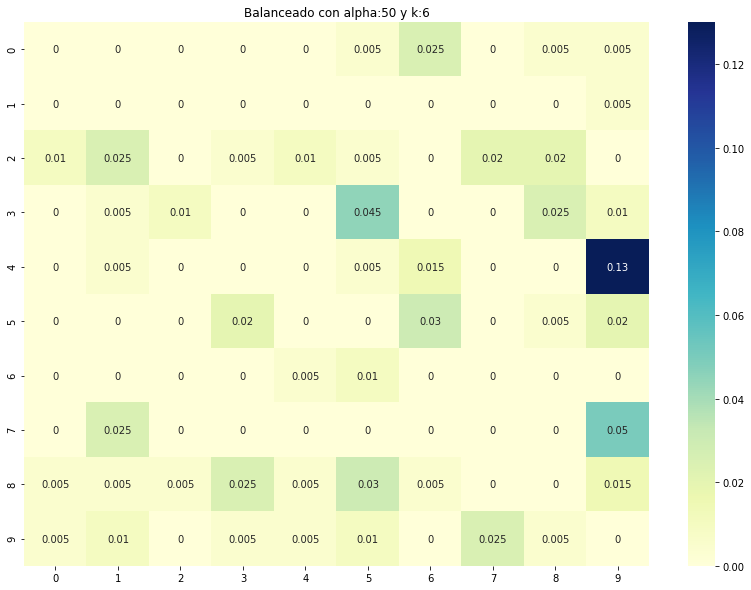

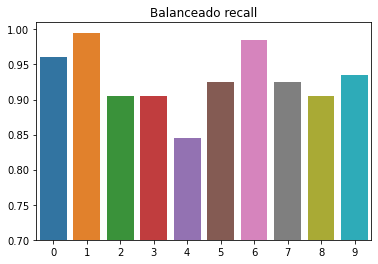

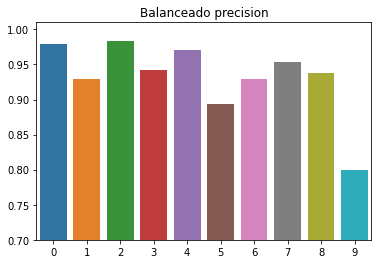

In [12]:
exp('Balanceado', resultados, k, alpha, trainDF1, testDF1)

La precision del 9 es muy mala, veamos si se puede mejorar agregando mas instancias de ese tipo

# Agrego instancias de 9s

In [13]:
addedAmmount = 400

mas9sTrain = df_datos.groupby("label").get_group(9).iloc[usedIndex:usedIndex+addedAmmount]
usedIndex += addedAmmount

In [14]:
trainDF2 = trainDF1.droplevel(0).append(mas9sTrain)
trainDF2["label"].value_counts()

9    700
7    300
5    300
3    300
1    300
8    300
6    300
4    300
2    300
0    300
Name: label, dtype: int64

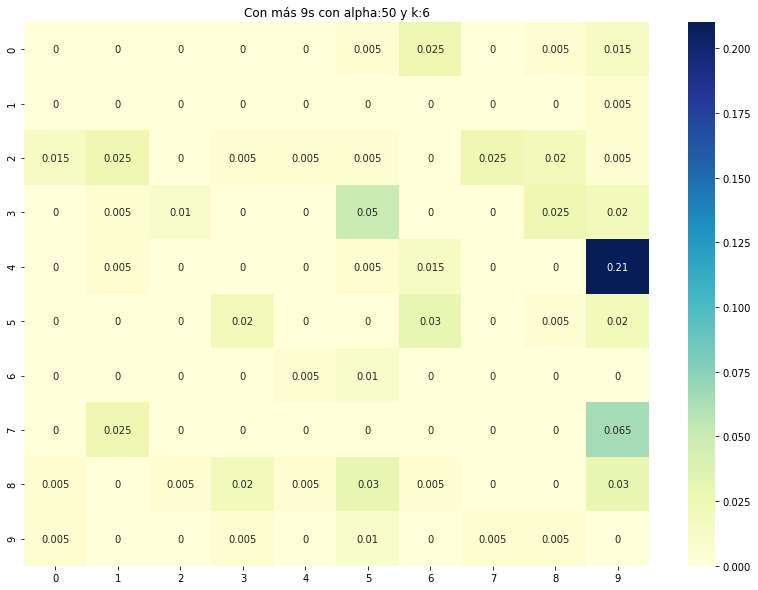

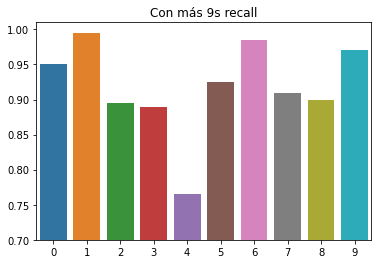

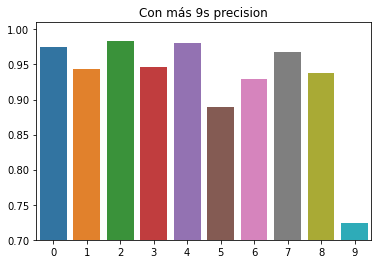

In [15]:
exp('Con más 9s', resultados, k, alpha, trainDF2, testDF1)

nop, se confunde muchos 4s con 9s entonces termina empeorando tanto el recall del 4 como la precision del 9

# Que pasa si en vez de 9s hubiesemos agregado 4s?

In [16]:
addedAmmount = 400

mas4sTrain = df_datos.groupby("label").get_group(4).iloc[usedIndex:usedIndex+addedAmmount]
usedIndex += addedAmmount

In [17]:
trainDF3 = trainDF1.droplevel(0).append(mas4sTrain)
trainDF3["label"].value_counts()

4    700
9    300
7    300
5    300
3    300
1    300
8    300
6    300
2    300
0    300
Name: label, dtype: int64

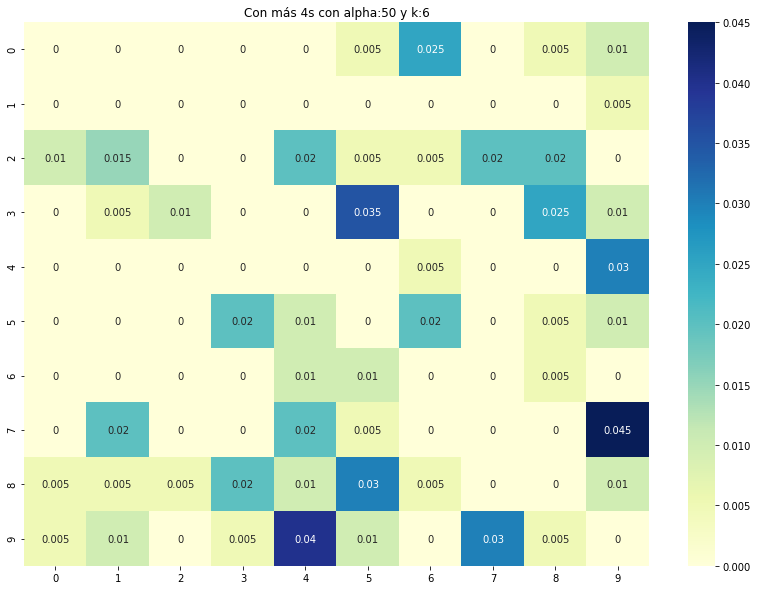

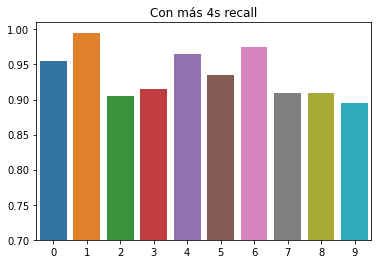

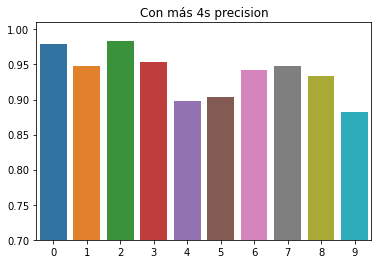

In [18]:
exp('Con más 4s', resultados, k, alpha, trainDF3, testDF1)

Mejora! mejor recall para el 4 sin bajar tanto el del 9 y mejor precisión en general.

# Comparando los resultados

In [55]:
resultsDF = pd.DataFrame(resultados)
resultsDF

,expName,acc,recall,precision,f1,y_val,y_pred,time
0,Balanceado,0.9285,"[0.96, 0.995, 0.905, 0.905, 0.845, 0.925, 0.98...","[0.9795918367346939, 0.9299065420560748, 0.983...","[0.9696969696969697, 0.9613526570048311, 0.942...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, ...",11.030143
1,Con más 9s,0.9185,"[0.95, 0.995, 0.895, 0.89, 0.765, 0.925, 0.985...","[0.9743589743589743, 0.943127962085308, 0.9835...","[0.9620253164556962, 0.9683698296836982, 0.937...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, ...",11.009461
2,Con más 4s,0.9360,"[0.955, 0.995, 0.905, 0.915, 0.965, 0.935, 0.9...","[0.9794871794871794, 0.9476190476190476, 0.983...","[0.9670886075949366, 0.9707317073170733, 0.942...","[[0], [0], [0], [0], [0], [0], [0], [0], [0], ...","[5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 9.0, ...",9.776404


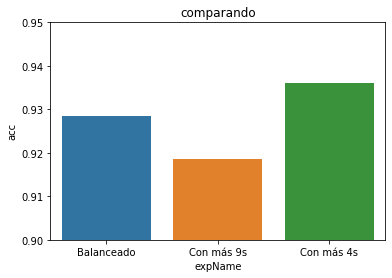

In [57]:
sns.barplot(x='expName', y='acc', data=resultsDF)
plt.title('comparando')
# plt.savefig(f"balanceo_results/acc.png")
plt.ylim(0.9, 0.95)
plt.show()

In [129]:
precisionsDF = resultsDF[['expName']].join(resultsDF['precision'].apply(pd.Series))
precisionsDF

,expName,0,1,2,3,4,5,6,7,8,9
0,Balanceado,0.979592,0.929907,0.983696,0.942708,0.971264,0.893720,0.929245,0.953608,0.937824,0.799145
1,Con más 9s,0.974359,0.943128,0.983516,0.946809,0.980769,0.889423,0.929245,0.968085,0.937500,0.723881
2,Con más 4s,0.979487,0.947619,0.983696,0.953125,0.897674,0.903382,0.942029,0.947917,0.933333,0.881773


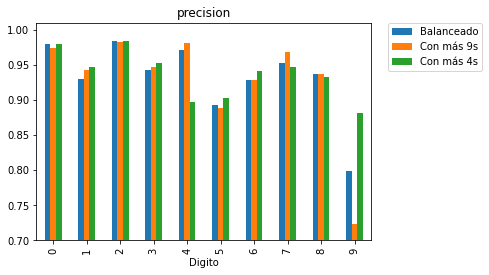

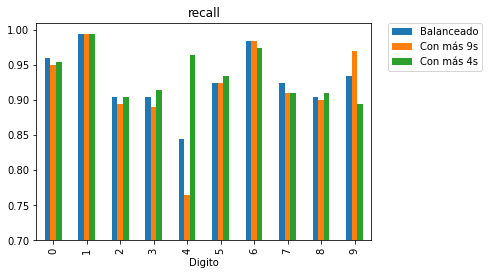

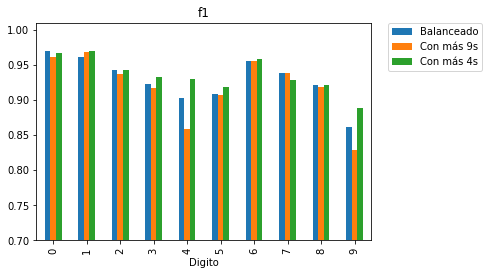

In [149]:
for metrica in ['precision', 'recall', 'f1']:
    df = resultsDF[metrica].apply(pd.Series).transpose().reset_index()
    df.columns = ['Digito'] + list(resultsDF['expName'])
    
    ax = plt.gca()
    df.plot(x=df.columns[0], y=df.columns[1:], kind = 'bar', ax = ax)
    plt.title(metrica)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
#     plt.savefig(f"balanceo_results/{metrica}_{n}.png")
    plt.ylim(0.7, 1.01)
    plt.show()